In [1]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import os
import math
import torch.nn as nn
from training_scripts.sMNIST.model import rnn
from training_scripts.sMNIST.dataset import MnistDataModule
import training_scripts.sMNIST.default_config as config
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.profilers import PyTorchProfiler

torch.set_float32_matmul_precision("medium")

In [2]:
PERMUTED = False
folder_name = "/vast/sr6364/dynamic-divisive-norm/tb_logs/rectified_input/sMNIST"
# model_name = "psMNIST_128_0.02_0.005_0.1_lr_0.01"
model_name = "sMNIST_64_0.05_0.01_0.1_lr_0.01_rectified_input"
version = 8
seed = 73

In [3]:
def load_model(epoch_number=None, model_name=None, folder_name=None, version=0):
    checkpoint_folder = f'{folder_name}/{model_name}/version_{version}/checkpoints/'
    hparams_path = f'{folder_name}/{model_name}/version_{version}/hparams.yaml'
    checkpoint_files = os.listdir(checkpoint_folder)
    epoch_idx = [int(file.split('epoch=')[1].split('-')[0]) for file in checkpoint_files]

    if epoch_number is not None:
        # If epoch number is provided, find the index of that epoch
        max_idx = epoch_idx.index(epoch_number)
    else:
        # If epoch number is not provided, find the index of the max epoch
        max_idx = epoch_idx.index(max(epoch_idx))

    checkpoint_path = os.path.join(checkpoint_folder, checkpoint_files[max_idx])
    # print(checkpoint_path)
    model = rnn.load_from_checkpoint(checkpoint_path=checkpoint_path, map_location='cpu', hparams_file=hparams_path)
    model.eval()
    return model


# model = load_model()

# epoch_no = 100
# model = load_model(epoch_no)

In [4]:
logger = TensorBoardLogger(folder_name, name="Inference")
dm = MnistDataModule(
    data_dir=config.DATA_DIR,
    batch_size=256,
    num_workers=2,
    permuted=PERMUTED,
    seed=seed
)
# calculate training accuracy using pytorch lightning
trainer = pl.Trainer(
    logger=logger,
    max_epochs=1
)

epoch_no = None
# epoch_no = 168
model = load_model(epoch_no, model_name, folder_name, version)

trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.23119999468326569
        test_loss            2.421675443649292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.23119999468326569, 'test_loss': 2.421675443649292}]

In [5]:
# trainer.test(model, dataloaders=dm.train_dataloader())

In [6]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

event_acc = EventAccumulator(logger.log_dir)
event_acc.Reload()

tags = event_acc.Tags()['scalars']
print(tags)
selected_tag = 'test_acc'
data = event_acc.Scalars(selected_tag)

# Extract steps and values
steps = [entry.step for entry in data]
values = [entry.value for entry in data]

# # Plot the data using matplotlib
# plt.plot(steps, values, label=selected_tag)
# plt.xlabel('Step')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

['hp_metric', 'test_acc', 'test_loss', 'epoch']


In [7]:
# plot the evolution of activations
y_example = torch.stack(model.activations["y"], dim=1).cpu()
a_example = torch.stack(model.activations["a"], dim=1).cpu()
b0_example = torch.stack(model.activations["b0"], dim=1).cpu()
b1_example = torch.stack(model.activations["b1"], dim=1).cpu()
print(y_example.shape)

torch.Size([256, 785, 64])


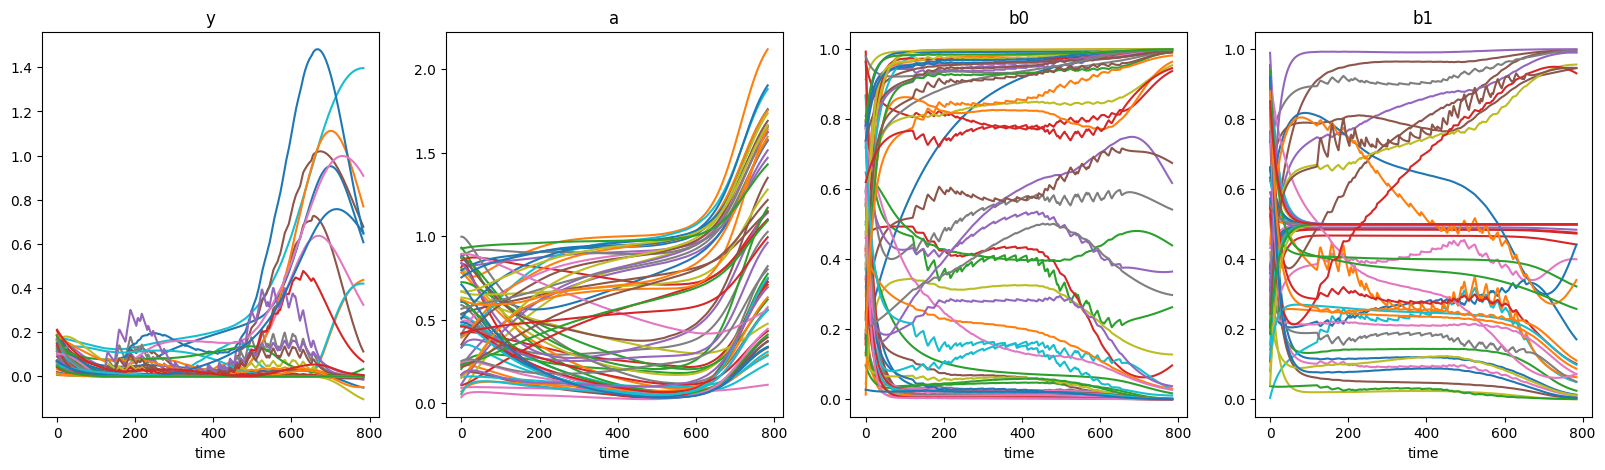

In [8]:
# plot y_example[0, :, :] and a_example[0, :, :] side by side
fig, axs = plt.subplots(1, 4)
# increase the figsze
batch_idx = 37
fig.set_size_inches(20, 5)
axs[0].plot(y_example[batch_idx, :, :])
axs[0].set_title('y')
axs[0].set_xlabel('time')

axs[1].plot(a_example[batch_idx, :, :])
axs[1].set_title('a')
axs[1].set_xlabel('time')

axs[2].plot(b0_example[batch_idx, :, :])
axs[2].set_title('b0')
axs[2].set_xlabel('time')

axs[3].plot(b1_example[batch_idx, :, :])
axs[3].set_title('b1')
axs[3].set_xlabel('time')
plt.show()

In [9]:
# Get the test dataloader
test_loader = dm.test_dataloader()

# Convert to an iterator
test_iter = iter(test_loader)

# Skip to the desired batch (e.g., third batch)
for _ in range(3):
    batch_data = next(test_iter)

# Unpack the inputs and labels
x, y = batch_data

# Print information
print(f"Inputs: {x.size()}")
print(f"Targets: {y.size()}")


Inputs: torch.Size([256, 1, 28, 28])
Targets: torch.Size([256])


In [10]:
batch_idx = 0
exploding_inp = x[batch_idx, :, :, :].reshape(1, 784, 1)
y_vals = y_example[batch_idx, :, :]
a_vals = a_example[batch_idx, :, :]
b0_vals = b0_example[batch_idx, :, :]
b1_vals = b1_example[batch_idx, :, :]
print(exploding_inp.shape)

torch.Size([1, 784, 1])


In [11]:
a_vals[:, 10]

tensor([0.8770, 0.8746, 0.8722, 0.8697, 0.8672, 0.8646, 0.8620, 0.8593, 0.8566,
        0.8538, 0.8510, 0.8482, 0.8453, 0.8425, 0.8396, 0.8367, 0.8337, 0.8308,
        0.8279, 0.8249, 0.8219, 0.8189, 0.8160, 0.8130, 0.8100, 0.8070, 0.8040,
        0.8010, 0.7981, 0.7951, 0.7921, 0.7892, 0.7862, 0.7833, 0.7804, 0.7774,
        0.7745, 0.7716, 0.7688, 0.7659, 0.7630, 0.7602, 0.7574, 0.7546, 0.7518,
        0.7490, 0.7462, 0.7435, 0.7408, 0.7381, 0.7354, 0.7327, 0.7301, 0.7274,
        0.7248, 0.7222, 0.7197, 0.7171, 0.7146, 0.7121, 0.7096, 0.7071, 0.7047,
        0.7023, 0.6999, 0.6975, 0.6951, 0.6928, 0.6905, 0.6882, 0.6859, 0.6837,
        0.6814, 0.6792, 0.6770, 0.6749, 0.6727, 0.6706, 0.6685, 0.6664, 0.6644,
        0.6624, 0.6603, 0.6584, 0.6564, 0.6545, 0.6525, 0.6506, 0.6488, 0.6469,
        0.6451, 0.6433, 0.6415, 0.6397, 0.6379, 0.6362, 0.6345, 0.6328, 0.6312,
        0.6295, 0.6279, 0.6263, 0.6248, 0.6232, 0.6217, 0.6202, 0.6187, 0.6172,
        0.6158, 0.6143, 0.6129, 0.6115, 

In [12]:
y_vals[:, 10]

tensor([ 0.1204,  0.1192,  0.1180,  0.1169,  0.1158,  0.1147,  0.1136,  0.1125,
         0.1115,  0.1104,  0.1094,  0.1084,  0.1074,  0.1064,  0.1054,  0.1044,
         0.1035,  0.1026,  0.1017,  0.1007,  0.0999,  0.0990,  0.0981,  0.0973,
         0.0964,  0.0956,  0.0948,  0.0940,  0.0932,  0.0924,  0.0916,  0.0908,
         0.0901,  0.0893,  0.0886,  0.0879,  0.0872,  0.0865,  0.0858,  0.0851,
         0.0844,  0.0837,  0.0831,  0.0824,  0.0818,  0.0811,  0.0805,  0.0799,
         0.0792,  0.0786,  0.0780,  0.0774,  0.0769,  0.0763,  0.0757,  0.0751,
         0.0746,  0.0740,  0.0735,  0.0729,  0.0724,  0.0719,  0.0713,  0.0708,
         0.0703,  0.0698,  0.0693,  0.0688,  0.0683,  0.0678,  0.0674,  0.0669,
         0.0664,  0.0659,  0.0655,  0.0650,  0.0646,  0.0641,  0.0637,  0.0633,
         0.0628,  0.0624,  0.0620,  0.0616,  0.0611,  0.0607,  0.0603,  0.0599,
         0.0595,  0.0591,  0.0587,  0.0583,  0.0580,  0.0576,  0.0572,  0.0568,
         0.0565,  0.0561,  0.0558,  0.05

In [13]:
b0_vals[:, 10]

tensor([0.1869, 0.1916, 0.1963, 0.2009, 0.2056, 0.2102, 0.2147, 0.2193, 0.2238,
        0.2283, 0.2327, 0.2372, 0.2416, 0.2460, 0.2503, 0.2547, 0.2590, 0.2633,
        0.2675, 0.2718, 0.2760, 0.2802, 0.2843, 0.2885, 0.2926, 0.2967, 0.3007,
        0.3048, 0.3088, 0.3128, 0.3168, 0.3207, 0.3247, 0.3286, 0.3324, 0.3363,
        0.3401, 0.3440, 0.3477, 0.3515, 0.3553, 0.3590, 0.3627, 0.3664, 0.3700,
        0.3737, 0.3773, 0.3809, 0.3845, 0.3880, 0.3916, 0.3951, 0.3986, 0.4021,
        0.4055, 0.4090, 0.4124, 0.4158, 0.4191, 0.4225, 0.4258, 0.4292, 0.4325,
        0.4357, 0.4390, 0.4422, 0.4455, 0.4487, 0.4518, 0.4550, 0.4582, 0.4613,
        0.4644, 0.4675, 0.4706, 0.4736, 0.4767, 0.4797, 0.4827, 0.4857, 0.4887,
        0.4916, 0.4945, 0.4975, 0.5004, 0.5032, 0.5061, 0.5090, 0.5118, 0.5146,
        0.5174, 0.5202, 0.5230, 0.5257, 0.5285, 0.5312, 0.5339, 0.5366, 0.5393,
        0.5419, 0.5446, 0.5472, 0.5498, 0.5524, 0.5550, 0.5576, 0.5601, 0.5627,
        0.5652, 0.5677, 0.5702, 0.5727, 

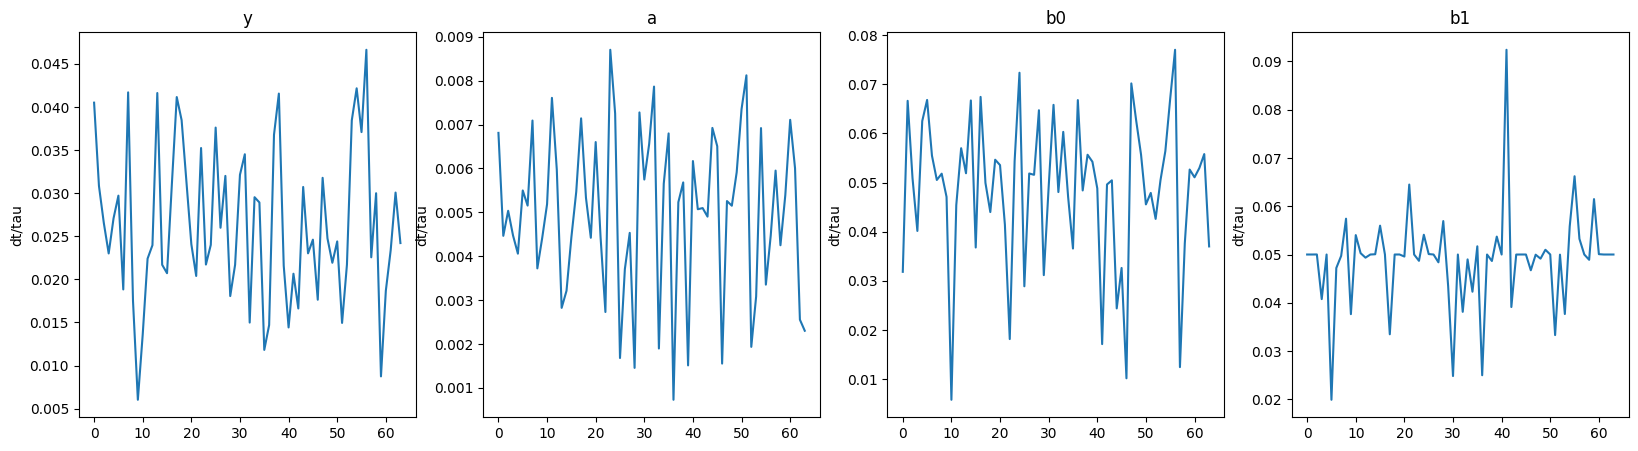

In [42]:
fig, axs = plt.subplots(1, 4)
# increase the figsze
batch_idx = 10
fig.set_size_inches(20, 5)
axs[0].plot(model.org.dt_tauy().detach())
axs[0].set_title('y')
axs[0].set_ylabel('dt/tau')

axs[1].plot(model.org.dt_taua().detach())
axs[1].set_title('a')
axs[1].set_ylabel('dt/tau')

axs[2].plot(model.org.dt_taub0().detach())
axs[2].set_title('b0')
axs[2].set_ylabel('dt/tau')

axs[3].plot(model.org.dt_taub1().detach())
axs[3].set_title('b1')
axs[3].set_ylabel('dt/tau')
plt.show()


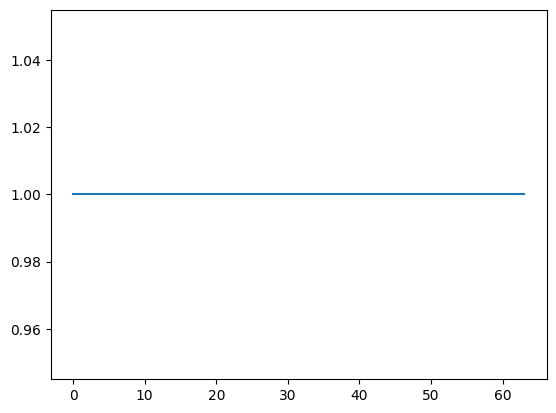

In [43]:
sigma = model.org.sigma.detach()
# plot it
plt.plot(abs(sigma))
# plot indices
plt.show()

We now analyze the dynamics of a and why they grow so much towards the end

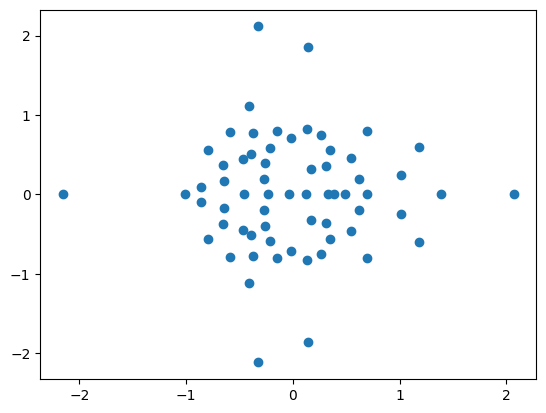

In [44]:
Wr = model.org.Wr().detach().cpu()

# calculate eigenvalues of Way
eigvals = torch.linalg.eigvals(Wr)
# plot the real and complex parts of the eigenvalues
plt.scatter(eigvals.real, eigvals.imag)
# xlim 0, 1
# plt.xlim(0, 5)
plt.show()

In [45]:
# print the max singular value of Wr
print(max(torch.linalg.svdvals(Wr)))


tensor(4.9118)


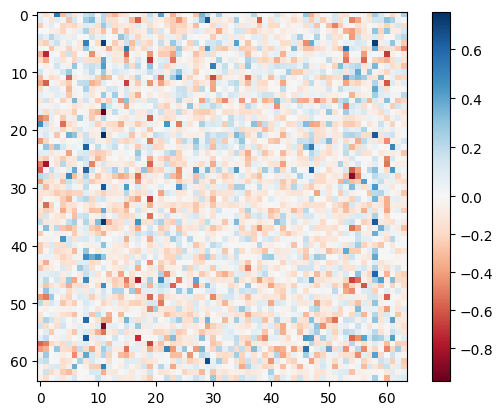

In [46]:
# Normalize the colormap based on your data range and center point
norm = TwoSlopeNorm(vmin=torch.min(Wr), vcenter=0.0, vmax=torch.max(Wr))
cmap = colormaps.get_cmap('RdBu')
# imshow the matrix Wr
plt.imshow(Wr, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [47]:
# Singular values of Wr
U, S, V = torch.svd(Wr)

# Print the singular values in non-scientific notation
print(" ".join(f"{value:.2f}," for value in S))

4.91, 4.24, 3.64, 3.34, 3.14, 2.12, 1.99, 1.92, 1.87, 1.60, 1.55, 1.48, 1.40, 1.36, 1.31, 1.28, 1.21, 1.16, 1.13, 1.12, 1.08, 1.06, 1.04, 1.01, 1.00, 0.99, 0.94, 0.92, 0.90, 0.88, 0.86, 0.84, 0.82, 0.81, 0.78, 0.78, 0.74, 0.72, 0.71, 0.69, 0.67, 0.66, 0.64, 0.62, 0.61, 0.53, 0.51, 0.50, 0.47, 0.44, 0.41, 0.39, 0.35, 0.33, 0.30, 0.25, 0.24, 0.22, 0.19, 0.18, 0.14, 0.11, 0.04, 0.01,


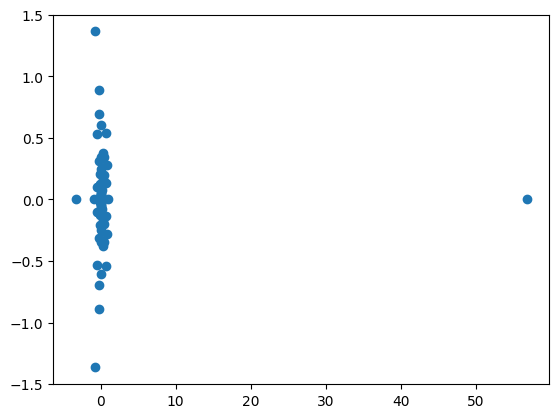

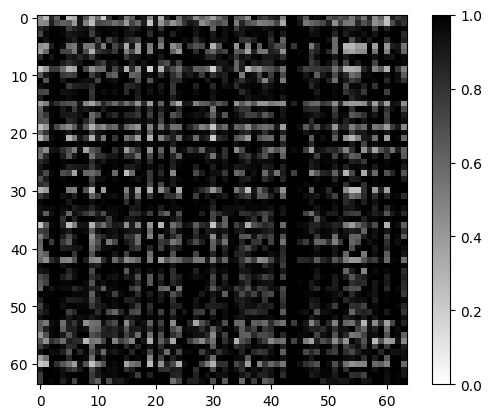

In [48]:
Way = model.org.Way().detach().cpu()


# calculate eigenvalues of Way
eigvals = torch.linalg.eigvals(Way)
# plot the real and complex parts of the eigenvalues

plt.scatter(eigvals.real, eigvals.imag)
# xlim 0, 1
# plt.xlim(0, 5)
plt.show()


vmin = 0
vmax = 1.0
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = colormaps.get_cmap('binary')
# imshow the matrix Wr
plt.imshow(Way, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

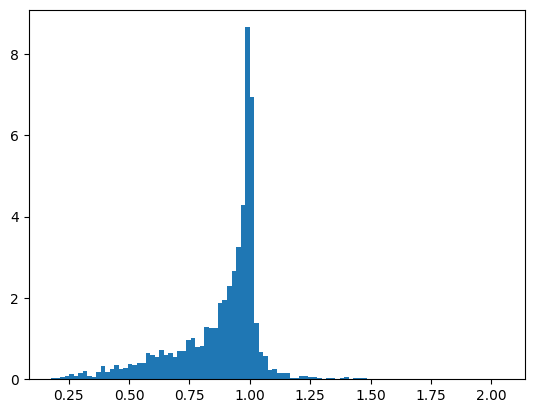

In [49]:
# Remove the largest value in Way
Way = model.org.Way().detach().cpu()
Way = Way.flatten()
# W_flat = Way[Way != Way.max()]

plt.hist(Way, bins=100, density=True)
# plt.xlim(0, 1)
plt.show()


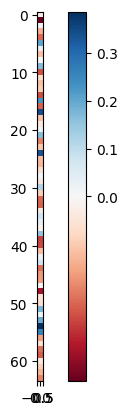

In [50]:
Wzx = model.org.Wzx().detach().cpu()
norm = TwoSlopeNorm(vmin=torch.min(Wzx), vcenter=0.0, vmax=torch.max(Wzx))
cmap = colormaps.get_cmap('RdBu')
# imshow the matrix Wr
# increase figure size
plt.imshow(Wzx, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

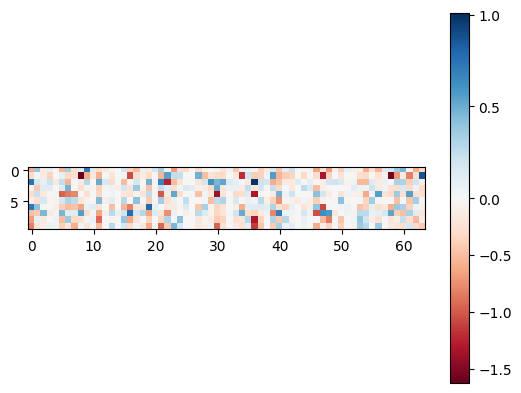

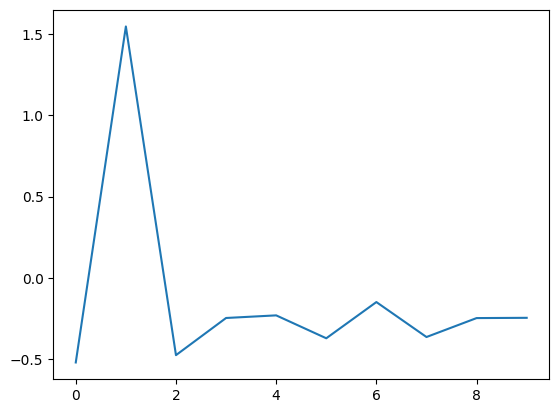

In [51]:
# plot the weights and biases in model.fc
W = model.fc.weight.detach().cpu()
b = model.fc.bias.detach().cpu()
norm = TwoSlopeNorm(vmin=torch.min(W), vcenter=0.0, vmax=torch.max(W))
cmap = colormaps.get_cmap('RdBu')
# imshow the matrix Wr

plt.imshow(W, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

# plot the biases
plt.plot(b)
plt.show()


In [52]:
def check_for_nan_parameters(model):
    for name, param in model.named_parameters():
        print(name)
        if torch.isnan(param).any():
            print(f"Parameter '{name}' contains NaN values.")
            return True
    print("No NaN values found in model parameters.")
    return False

# Usage
has_nan = check_for_nan_parameters(model.org)

Wbx0
Wby0
Wba0
Wbx1
Wby1
Wba1
log_Way
sigma
param_dt_tauy
param_dt_taua
param_dt_taub0
param_dt_taub1
Wzx.weight
Wr.weight
No NaN values found in model parameters.


In [56]:
def check_forward_pass_for_nan(model, dataloader):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for batch_idx, batch in enumerate(dataloader):
            x, target = batch
            print(f"Processing batch {batch_idx + 1}...")

            # Reshape inputs for sequential tasks
            x = model._transform_inputs(x)

            # Initialize hidden states
            y = model.y0.repeat(x.size(0), 1)
            a = model.a0.repeat(x.size(0), 1)
            b0 = model.b00.repeat(x.size(0), 1)
            b1 = model.b10.repeat(x.size(0), 1)

            # Forward pass through the sequence
            for i in range(model.seq_length):
                y, a, b0, b1 = model.org(x[:, i, :], y, a, b0, b1)
                if torch.isnan(y).any() or torch.isnan(a).any() or torch.isnan(b0).any() or torch.isnan(b1).any():
                    print(f"NaN detected in activations at time step {i} in batch {batch_idx + 1}")
                    return

            # Get final output logits
            scores = model.fc(y)
            if torch.isnan(scores).any():
                print(f"NaN detected in scores in batch {batch_idx + 1}")
                return

            # Calculate loss
            loss = model.loss_fn(scores, target)
            if torch.isnan(loss).any():
                print(f"NaN detected in loss in batch {batch_idx + 1}")
                return

            print(f"Batch {batch_idx + 1} processed successfully. Loss: {loss.item()}")

# Assuming you have the test dataloader from your DataModule
test_loader = dm.test_dataloader()
train_loader = dm.train_dataloader()

# Run the forward pass check
check_forward_pass_for_nan(model, test_loader)


Processing batch 1...
Batch 1 processed successfully. Loss: 1.438590407371521
Processing batch 2...
Batch 2 processed successfully. Loss: 1.5491374731063843
Processing batch 3...
NaN detected in activations at time step 778 in batch 3


In [ ]:
# get the third batch from the dataloader
for batch in train_loader:
    x, target = batch
    break
